In [8]:
import argparse
import sys
import os

import random

import time
import datetime

from collections import Counter
import numpy as np

import shutil
import inspect

import gc

import re

import keras
from keras import models
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, GlobalAveragePooling1D
from keras import optimizers

from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

from keras import backend as K

import tensorflow as tf

from IPython.display import display
from PIL import Image

import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from mlxtend.plotting import plot_confusion_matrix



In [9]:
# Creates directory, if directory exists removes if remove parameter is set to True 
def create_directory(directory_path, remove=False):
    if remove and os.path.exists(directory_path):
        try:
            shutil.rmtree(directory_path)
            os.mkdir(directory_path)
        except:
            print("Could not remove directory : ", directory_path)
            return False
    else:
        try:
            os.mkdir(directory_path)
        except:
            print("Could not create directory: ", directory_path)
            return False
        
    return True

# Removes directory, if directory exists 
def remove_directory(directory_path):
    if os.path.exists(directory_path):
        try:
            shutil.rmtree(directory_path)
        except:
            print("Could not remove directory : ", directory_path)
            return False
        
    return True

In [10]:
# print date and time for given type of representation
def date_time(x):
    if x==1:
        print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
    if x==2:    
        print('Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now()))
    if x==3:  
        print('Date now: %s' % datetime.datetime.now())
    if x==4:  
        print('Date today: %s' % datetime.date.today())  

In [11]:
# prints a integer for degugging
def debug(x):
    print("-"*40, x, "-"*40)  

In [12]:
# Removes everything except alphabetical and selected characters from name string
def name_correct(name):
    return re.sub(r'[^a-zA-Z,:]', ' ', name).title()

In [13]:
# reset tensorflow graph tp free up memory and resource allocation 
def reset_graph(model=None):
    try:
        del model
    except:
        return False
    
    tf.reset_default_graph()
    
    K.clear_session()
    
    gc.collect()
    
    return True


# reset callbacks 
def reset_callbacks(checkpoint=None, reduce_lr=None, early_stopping=None, tensorboard=None):
    checkpoint=None
    reduce_lr = None
    early_stopping = None
    tensorboard = None
    

In [14]:
x=1
date_time(x)
reset_graph(model)

Timestamp: 2018-12-07 09:18:15


NameError: name 'model' is not defined

In [15]:
# Configure input/ output directory
# Configure training, validation, testing directory

input_directory = r"data/input/"
output_directory = r"data/output/"

training_dir = input_directory+ r"train_final"
testing_dir = input_directory+ r"test_final"
validation_dir = input_directory+ r"validation_final"

classes = os.listdir(training_dir)
classes = ['Normal', 'Cancer']

In [16]:
target_size = (299,299)

rescale=1/255.0
# batch_size = 32

batch_size = 128

datagen = ImageDataGenerator(
    rescale=rescale)     

train_generator = datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    classes = classes,
    class_mode='categorical',
    batch_size=batch_size)

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    classes = classes,
    class_mode='categorical',
    batch_size=batch_size)    

test_generator = datagen.flow_from_directory(
    testing_dir,
    target_size=target_size,
    classes = classes,
    class_mode='categorical',
    batch_size=batch_size)

Found 132016 images belonging to 2 classes.
Found 44005 images belonging to 2 classes.
Found 44004 images belonging to 2 classes.


In [17]:
#--------------------------------------------------------------------------------------------------------------------#
# Model Directory
#--------------------------------------------------------------------------------------------------------------------#
model_dir=output_directory + r"models/"+time.strftime('%Y-%m-%d %H-%M-%S')+"/"
# model_dir=output_directory + r"models/"+time.strftime('%Y%m%d%H%M%S')+"/"
#--------------------------------------------------------------------------------------------------------------------#
# Log Directory
#--------------------------------------------------------------------------------------------------------------------#
# log_dir=output_directory + r"logs/"+time.strftime('%Y%m%d%H%M%S')
log_dir=output_directory + r"logs/"+time.strftime('%Y-%m-%d %H-%M-%S')
#--------------------------------------------------------------------------------------------------------------------#



# Create Output Directory (Model and Log)
#--------------------------------------------------------------------------------------------------------------------#
create_directory(model_dir, remove=True)
create_directory(log_dir, remove=True)
#--------------------------------------------------------------------------------------------------------------------#


#--------------------------------------------------------------------------------------------------------------------#
# Model File Name Configuration
#------------------------------------------------------------------------------------------------------#

#--------------------------------------------------------------------------------------------------------------------#
# Initial Trainning Model Filename 
#----------------------------------------------------------------------------------------------------#
init_model_file=model_dir+"base-"+"{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"
#--------------------------------------------------------------------------------------------------------------------#

#--------------------------------------------------------------------------------------------------------------------#
# Trainning Model Filename 
#----------------------------------------------------------------------------------------------------#
model_file=model_dir+"{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"
#--------------------------------------------------------------------------------------------------------------------#

#--------------------------------------------------------------------------------------------------------------------#
# Retrainning Model Filename 
#----------------------------------------------------------------------------------------------------#
retrain_model_file=model_dir+"retrain-{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"
#--------------------------------------------------------------------------------------------------------------------#

In [18]:
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x) 

model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False

    
# if print_layers:
#     for i, layer in enumerate(base_model.layers):
#         print(i, layer.name)


for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [19]:
checkpoint = ModelCheckpoint(
    model_file, 
    monitor='val_loss',
    verbose=0,
    save_best_only=False, 
    save_weights_only=False, 
    mode='auto',
    period=1)

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0, 
    patience=0, 
    verbose=0, 
    mode='auto', 
    baseline=None, 
    restore_best_weights=False)


tensorboard = TensorBoard(
    log_dir=log_dir,
    histogram_freq=0, 
    batch_size=batch_size, 
    write_graph=True, 
    write_grads=False, 
    write_images=False, 
    embeddings_freq=0,
    embeddings_layer_names=None, 
    embeddings_metadata=None, 
    embeddings_data=None, 
    update_freq='epoch')


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1,
    patience=10, 
    verbose=0, 
    mode='auto', 
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)


In [20]:
# callbacks = [checkpoint, reduce_lr, early_stopping, tensorboard]
callbacks = [checkpoint, tensorboard]


In [21]:
date_time(1)

optimizer=optimizers.Adam(lr=0.00001)
loss='categorical_crossentropy'
metrics=['accuracy']


model.compile(optimizer, loss=loss, metrics=metrics)

history = model.fit_generator(
    train_generator,
    steps_per_epoch = 300,
    epochs=10,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=75)
date_time(1)


Timestamp: 2018-12-07 09:19:54
Epoch 1/10
 23/300 [=>............................] - ETA: 25:56 - loss: 0.6027 - acc: 0.6787

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Andromeda\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-0be2f5fbf14e>", line 15, in <module>
    validation_steps=75)
  File "C:\Users\Andromeda\Anaconda3\lib\site-packages\keras\legacy\interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\Andromeda\Anaconda3\lib\site-packages\keras\engine\training.py", line 1418, in fit_generator
    initial_epoch=initial_epoch)
  File "C:\Users\Andromeda\Anaconda3\lib\site-packages\keras\engine\training_generator.py", line 181, in fit_generator
    generator_output = next(output_generator)
  File "C:\Users\Andromeda\Anaconda3\lib\site-packages\keras\utils\data_utils.py", line 685, in get
    inputs = self.queue.get(block=True).get()
  File "C:\Users\Andromeda\Anaconda3\lib\multiprocessing\pool.py", line 638, in get
    self.wait(timeout)
  File "C:\U

KeyboardInterrupt: 

In [ ]:
# model_dir = "data/output/models/"

# dirs = os.listdir(model_dir)
# for i in range(len(dirs)):
#     print(i, dirs[i])

In [ ]:
# current_dir = model_dir+dirs[0]+"/"

# print(current_dir)
# cur_models = os.listdir(current_dir)
# for i in range(len(cur_models)):
#     print(i, cur_models[i])

In [ ]:
# cur_model = cur_models[0]
# model_file = current_dir+cur_model
# print(model_file)

In [ ]:
# model = keras.models.load_model(model_file)

In [ ]:
date_time(1)
# result = model.evaluate_generator(generator=test_generator, steps=100, verbose=1)
result = model.evaluate_generator(generator=test_generator, steps=len(test_generator), verbose=1)
        
    
accuracy = result[1]*100
loss = result[0]

print("%s%.2f%s"% ("Accuracy: ", accuracy, "%"))
print("%s%.2f"% ("Loss: ", loss))

date_time(1)

In [ ]:
date_time(1)

y_preds = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)
        
y_classes = y_preds.argmax(axis=-1)
date_time(1)

NameError: name 'cur_model' is not defined

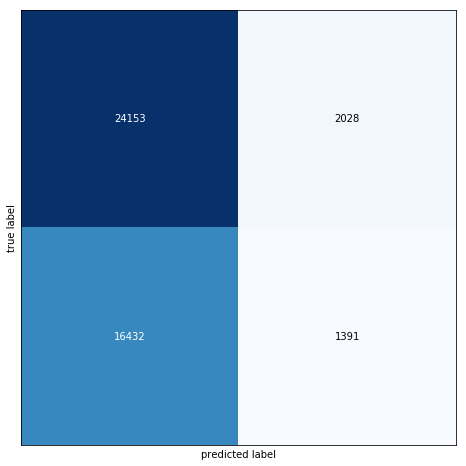

In [30]:
cur_model = date(1)
CM = confusion_matrix(test_generator.classes, y_classes)

fig, ax = plot_confusion_matrix(
    conf_mat=CM ,  
    figsize=(10,8), 
    hide_ticks=True,cmap=plt.cm.Blues)
plt.title("Model File: "+cur_model)
plt.xticks(range(len(classes)), classes, fontsize=14)
plt.yticks(range(len(classes)), classes, fontsize=14)
cm_name = "data/output/figures/CM-"+cur_model[:-5]+".png",
# print(cm_name)
plt.savefig("data/output/figures/CM"+cur_model+".png", dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)
plt.show()

In [ ]:
CM = confusion_matrix(test_generator.classes, y_classes)

cls_report_print = classification_report(test_generator.classes, y_classes, target_names=classes)

# cls_report = classification_report(test_generator.classes, y_classes, target_names=classes, output_dict=True)

# if print_report: 
print(cls_report_print)


In [ ]:
# data/output/models/old/12-val_acc-0.70-val_loss-1.09.hdf5
# Accuracy: 31.44%
# Loss: 3.32
# 